**Background:**

I have been provided with a dataset representing the COVID-19 infections over the years 2020 and 2023.The dataset contains the latest version of data.

**Task:**

This code analyzes the COVID-19 infection trends from the Johns Hopkins University dataset, focusing on predictive modeling, clustering, and graph analytics to identify and visualize the infection trends of the top three infected countries and their neighboring countries, aiding decision-making for pandemic response.

In [1]:
!pip install threadpoolctl==3.1.0

In [2]:
pip install networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


Importing all the librairies 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
import networkx as nx
from datetime import datetime


In [4]:
# Load the dataset
df = pd.read_csv('time_series_covid19_confirmed_global.csv') 

df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


Converting days to week

In [5]:
#  Reshape the DataFrame from wide format to long format
df_long = df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Cases")

# Converting dates to datetime
df_long['Date'] = pd.to_datetime(df_long['Date'], format='%m/%d/%y')

# Initializing the 'WeekNumber' column
df_long["WeekNumber"] = np.nan

# Defining the start date
start_date = datetime(2020, 1, 22)

# Assigning week number to each row based on the 'Date' column
for index, row in df_long.iterrows():
    week_number = ((row['Date'] - start_date).days // 7) + 1
    df_long.at[index, 'WeekNumber'] = week_number

# Aggregating the cases by country and week, computing cumulative totals
df_weekly = df_long.groupby(['Country/Region', 'WeekNumber']).agg({'Cases': 'max'}).reset_index()





In [6]:
# Calculating weekly new cases by computing the difference between each week
df_weekly['New Cases'] = df_weekly.groupby('Country/Region')['Cases'].diff().fillna(df_weekly['Cases'])

print(df_weekly.head(20))

   Country/Region  WeekNumber  Cases  New Cases
0     Afghanistan         1.0      0        0.0
1     Afghanistan         2.0      0        0.0
2     Afghanistan         3.0      0        0.0
3     Afghanistan         4.0      0        0.0
4     Afghanistan         5.0      5        5.0
5     Afghanistan         6.0      5        0.0
6     Afghanistan         7.0      8        3.0
7     Afghanistan         8.0     26       18.0
8     Afghanistan         9.0     42       16.0
9     Afghanistan        10.0    166      124.0
10    Afghanistan        11.0    367      201.0
11    Afghanistan        12.0    665      298.0
12    Afghanistan        13.0   1026      361.0
13    Afghanistan        14.0   1703      677.0
14    Afghanistan        15.0   2469      766.0
15    Afghanistan        16.0   4967     2498.0
16    Afghanistan        17.0   7655     2688.0
17    Afghanistan        18.0  11917     4262.0
18    Afghanistan        19.0  16578     4661.0
19    Afghanistan        20.0  21308    

Data Analysis: The top 3 countries with highest number of cases were identified.

In [7]:
# Find the latest week number for each country and select the corresponding max cases
latest_cases_by_country = df_weekly.groupby('Country/Region').agg({'Cases': 'max'}).sort_values(by='Cases', ascending=False)

# Picked the top three countries with the highest cumulative cases
top_three_countries = latest_cases_by_country.head(3)
print("Top three countries with the highest cumulative cases:")
print(top_three_countries)

Top three countries with the highest cumulative cases:
                    Cases
Country/Region           
US              103802702
India            44690738
France           38618509


The top three countries' weekly infections were plotted in a line graph for visual interpretation.

C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

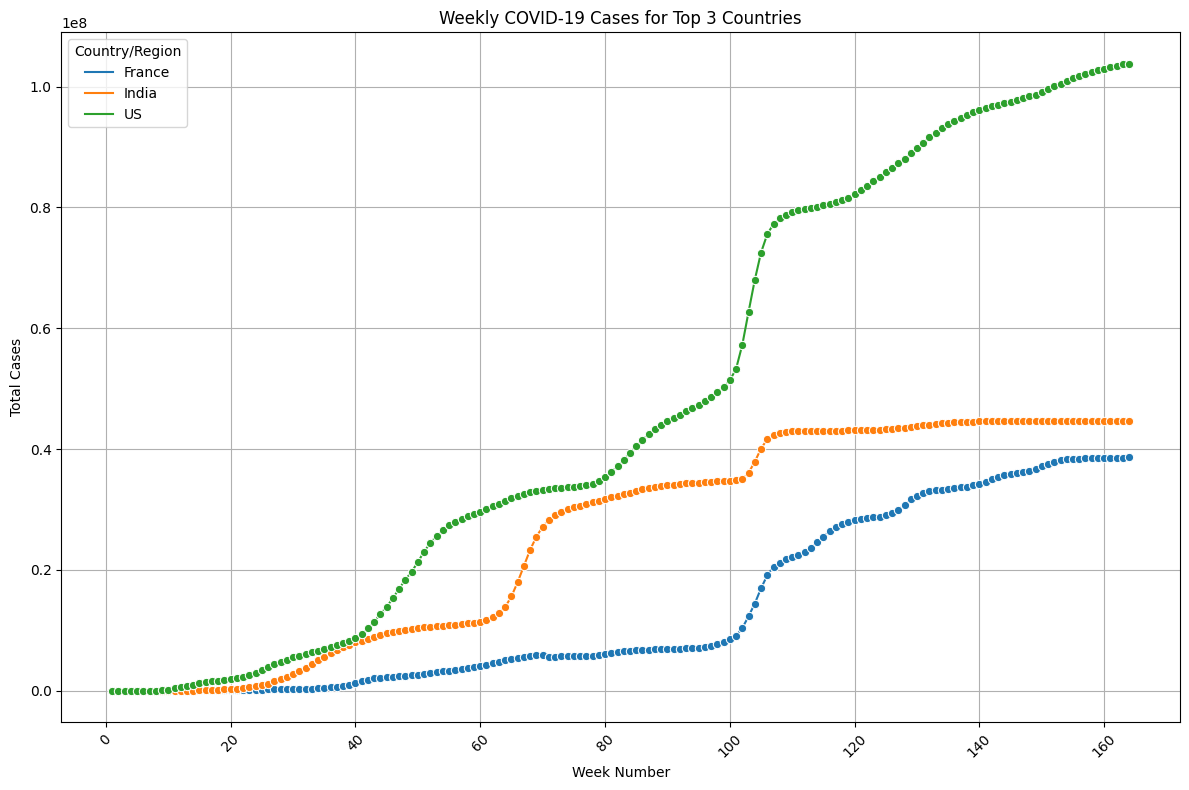

In [8]:
# Filtered the df_weekly DataFrame to only include these top three countries
df_top_three = df_weekly[df_weekly['Country/Region'].isin(top_three_countries.index)]

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_top_three, x='WeekNumber', y='Cases', hue='Country/Region', marker='o')
plt.title('Weekly COVID-19 Cases for Top 3 Countries')
plt.xlabel('Week Number')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Country/Region')
plt.tight_layout()
plt.show()

# Predictive modelling

**Fitting a linear regression model for each of the top infected countires.**

In [9]:
top_countries = top_three_countries.index.tolist()

# Created a dictionary to store the models and their coefficients for each country
models = {}
coefficients = {}
scores = {}

# Fitting the model for each of the top three countries
for country in top_countries:
    # Filter and sort the data for the current country
    country_data = df_weekly[df_weekly['Country/Region'] == country].sort_values('WeekNumber')
    
    # Calculated weekly new cases
    country_data['New_Cases'] = country_data['Cases'].diff().fillna(0)  
    
    # Preparing the features (WeekNumber) and the target variable (New_Cases)
    X = country_data[['WeekNumber']]
    y = country_data['New_Cases']
    
    # Initializing and fitting the Linear Regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Stored the model and its coefficients
    models[country] = model
    coefficients[country] = (model.coef_[0], model.intercept_)
    scores[country] = model.score(X, y)  

# Output the coefficients and R-squared for each model
for country, (coef, intercept) in coefficients.items():
    score = scores[country]
    print(f"Model for {country}: Coefficient = {coef:.2f}, Intercept = {intercept:.2f}, R-squared = {score:.2f}")


Model for US: Coefficient = 2068.93, Intercept = 462256.70, R-squared = 0.02
Model for India: Coefficient = -1428.44, Intercept = 390351.11, R-squared = 0.02
Model for France: Coefficient = 2489.66, Intercept = 30081.99, R-squared = 0.09


**Predicting the future infections of top 3 countries on weekly basis**

In [10]:
last_week_number = df_weekly['WeekNumber'].max()

future_weeks = np.arange(last_week_number + 1, last_week_number + 3)

# stored cumulative predictions and new cases predictions for each country in a dictionary
cumulative_predictions = {}
new_cases_predictions = {}

# Predicted future cumulative cases for each of the top three countries
for country, model in models.items():
    future_X = np.array(future_weeks).reshape(-1, 1)
    cumulative_predictions[country] = model.predict(future_X)
    # Then Calculated new cases by finding the difference between consecutive weeks
    new_cases = np.diff(cumulative_predictions[country], prepend=model.predict(np.array([[last_week_number]])))
    new_cases_predictions[country] = new_cases

# Print the new cases predictions for each country
for country, predictions in new_cases_predictions.items():
    print(f"Predictions for {country} for the next 2 weeks:")
    for week, prediction in zip(future_weeks, predictions):
        print(f"Week {week}: {prediction:.2f} new cases")
    print()  # Adds a blank line for better readability between countries


Predictions for US for the next 2 weeks:
Week 165.0: 2068.93 new cases
Week 166.0: 2068.93 new cases

Predictions for India for the next 2 weeks:
Week 165.0: -1428.44 new cases
Week 166.0: -1428.44 new cases

Predictions for France for the next 2 weeks:
Week 165.0: 2489.66 new cases
Week 166.0: 2489.66 new cases



C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not ha

**Identifying the country with highest variance**

In [12]:
# Calculated the variance for each country based on existing new cases data
new_case_variances = df_weekly[df_weekly['Country/Region'].isin(top_countries)].groupby('Country/Region')['New Cases'].var().sort_values(ascending=False)

# Identifying the country with the highest variance in new cases
print("Country with the highest variance in weekly new COVID-19 cases:")
print(new_case_variances.head(3))


Country with the highest variance in weekly new COVID-19 cases:
Country/Region
US        6.351888e+11
India     2.480016e+11
France    1.547382e+11
Name: New Cases, dtype: float64


**US has the highest variance.**

# Clustering

Clustering: Performed K-Means clustering on the distance data to categorize weekly new cases into different performance groups. To identify patterns and group characteristics.

In [13]:
# Filtered the data for USA
usa_data = df_weekly[df_weekly['Country/Region'] == 'US']

In [14]:
# Setting 'WeekNumber' as the index and prepare the data frame
usa_data = usa_data.set_index('WeekNumber')
usa_data = usa_data[['New Cases']]  # Assuming 'New Cases' is calculated as shown earlier

In [15]:
X = usa_data.copy()


In [16]:
# Determine the optimal number of clusters using the Elbow method through iteration
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

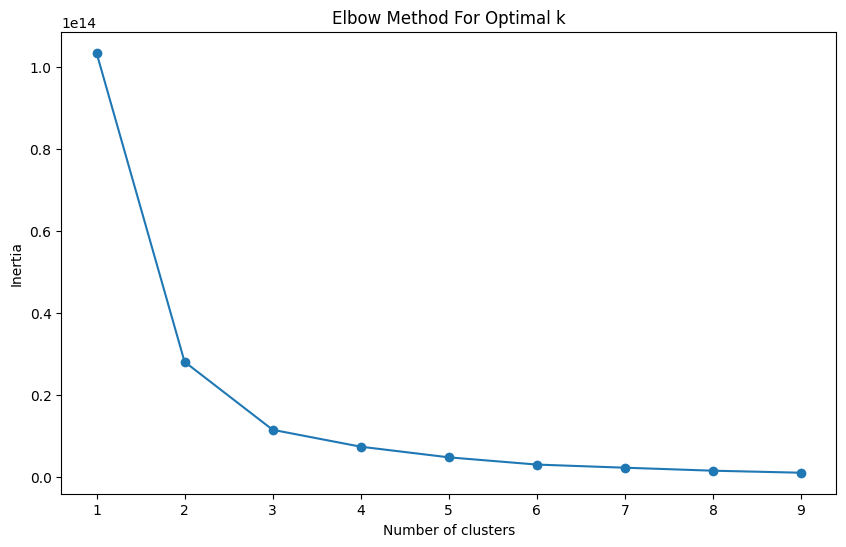

In [17]:
# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [18]:
#Optimal number of clusters is determined to be 3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(scale(X))  # Scaling the data

C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [19]:
clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
X_scaled=scale(X)
X_scaled

array([[-7.96595913e-01],
       [-7.96594654e-01],
       [-7.96599688e-01],
       [-7.96600947e-01],
       [-7.96599688e-01],
       [-7.96529208e-01],
       [-7.95711139e-01],
       [-7.89390611e-01],
       [-7.33419573e-01],
       [-6.26236145e-01],
       [-5.15718769e-01],
       [-5.29722856e-01],
       [-5.47189263e-01],
       [-5.45699118e-01],
       [-5.58119926e-01],
       [-5.88510568e-01],
       [-6.00353693e-01],
       [-6.08063681e-01],
       [-6.15437631e-01],
       [-6.10160455e-01],
       [-5.97224893e-01],
       [-5.28708450e-01],
       [-4.18972645e-01],
       [-3.47178891e-01],
       [-2.49249713e-01],
       [-2.22740494e-01],
       [-2.25070104e-01],
       [-2.86301955e-01],
       [-2.91844689e-01],
       [-3.60364908e-01],
       [-4.28122435e-01],
       [-4.29499308e-01],
       [-4.71754471e-01],
       [-4.51048510e-01],
       [-4.29295420e-01],
       [-4.26191791e-01],
       [-4.13314123e-01],
       [-3.45158889e-01],
       [-2.5

In [21]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head(100)

,New Cases
0,-0.796596
1,-0.796595
2,-0.796600
3,-0.796601
4,-0.796600
...,...
95,0.044956
96,-0.067052
97,0.266471
98,0.258668


In [22]:
X_scaled_df['Cluster'] = clusters
X_scaled_df.head(100)

,New Cases,Cluster
0,-0.796596,0
1,-0.796595,0
2,-0.796600,0
3,-0.796601,0
4,-0.796600,0
...,...,...
95,0.044956,0
96,-0.067052,0
97,0.266471,2
98,0.258668,2


In [23]:
# Adding cluster information back to DataFrame
usa_data['Cluster'] = clusters

C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


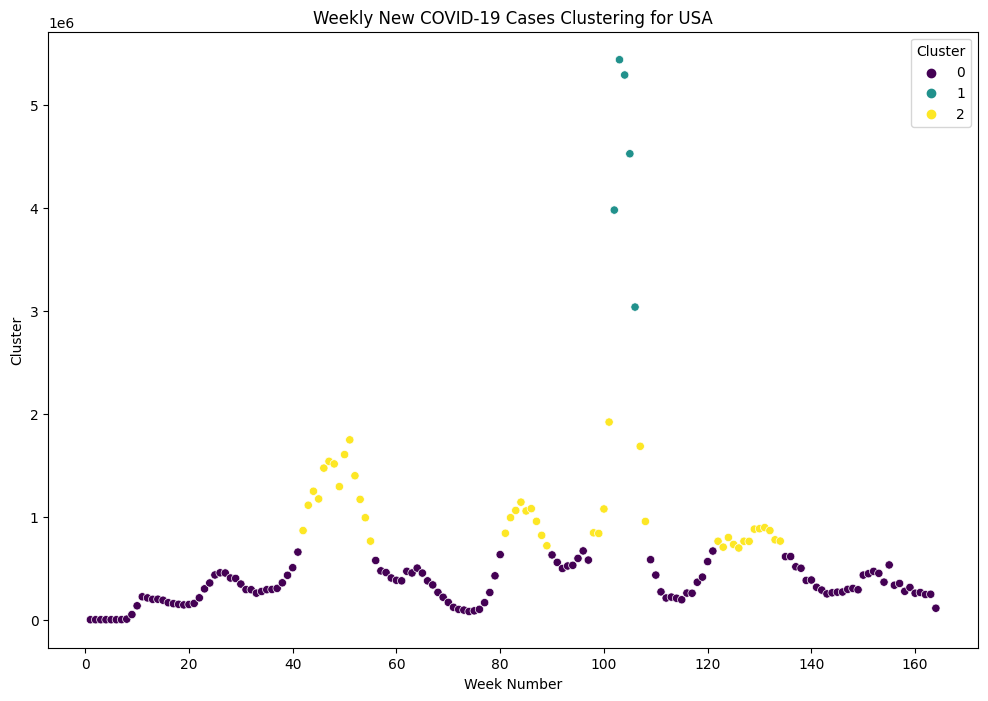

In [24]:
# Plotting the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=usa_data.index, y='New Cases', hue='Cluster', data=usa_data, palette='viridis', legend='full')
plt.title('Weekly New COVID-19 Cases Clustering for USA')
plt.xlabel('Week Number')
plt.ylabel('Cluster')
plt.show()

In [25]:
usa_data['Cluster'] = clusters
print(usa_data)
print(usa_data.dtypes)

            New Cases  Cluster
WeekNumber                    
1.0               5.0        0
2.0               6.0        0
3.0               2.0        0
4.0               1.0        0
5.0               2.0        0
...               ...      ...
160.0        257530.0        0
161.0        264445.0        0
162.0        244786.0        0
163.0        247455.0        0
164.0        111792.0        0

[164 rows x 2 columns]
New Cases    float64
Cluster        int32
dtype: object


In [26]:
usa_data.head(100)

,New Cases,Cluster
WeekNumber,,
1.0,5.0,0
2.0,6.0,0
3.0,2.0,0
4.0,1.0,0
5.0,2.0,0
...,...,...
96.0,668663.0,0
97.0,579667.0,0
98.0,844669.0,2


In [27]:
# Print cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)

Cluster Centers:
[[-0.39489705]
 [ 4.81255457]
 [ 0.52714718]]


In [28]:
print(usa_data.dtypes)

New Cases    float64
Cluster        int32
dtype: object


In [29]:
#Analyzed cluster properties, such as count per cluster for clear understanding
cluster_summary = usa_data.groupby('Cluster')['New Cases'].describe()
print(cluster_summary)

         count          mean            std        min         25%        50%  \
Cluster                                                                         
0        117.0  3.191764e+05  171453.445928        1.0   208868.00   295052.0   
1          5.0  4.456777e+06  989276.171951  3038462.0  3981089.00  4528340.0   
2         42.0  1.051790e+06  320664.084354   696904.0   804247.75   955678.5   

               75%        max  
Cluster                        
0         450599.0   668663.0  
1        5293802.0  5442191.0  
2        1172779.0  1920877.0  


**Outlier Detection:** Used statistical methods to detect any outliers in the weekly cases of USA.

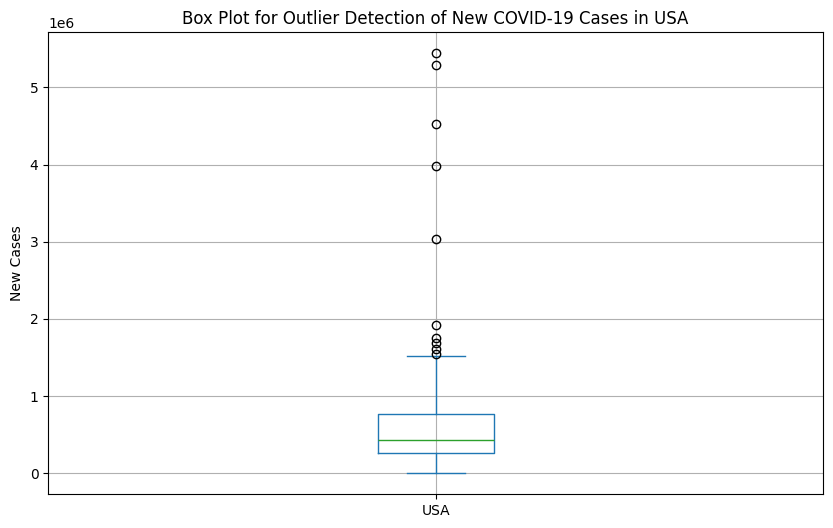

In [30]:
plt.figure(figsize=(10, 6))
usa_data['New Cases'].plot.box()
plt.title('Box Plot for Outlier Detection of New COVID-19 Cases in USA')
plt.ylabel('New Cases')
plt.xticks([1], ['USA'])
plt.grid(True)
plt.show()

C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


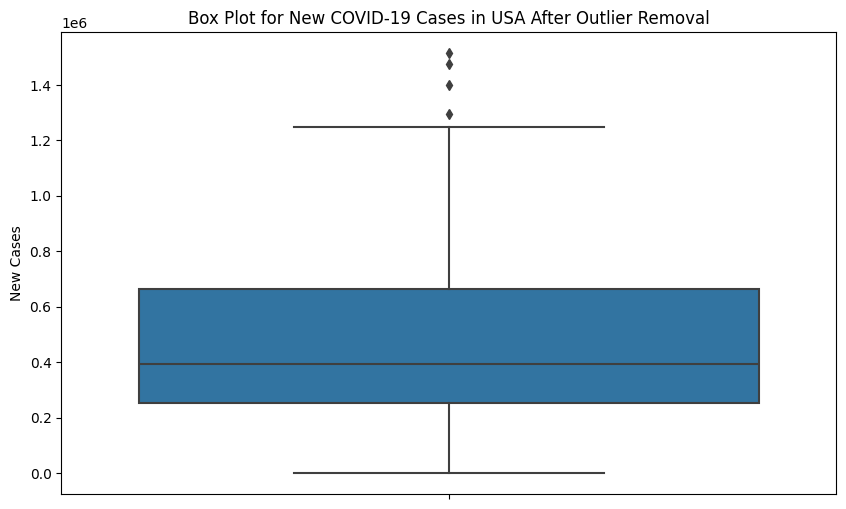

In [31]:
# Identify outliers using IQR for New Cases in the USA data
Q1 = usa_data['New Cases'].quantile(0.25)
Q3 = usa_data['New Cases'].quantile(0.75)
IQR = Q3 - Q1

# Determine bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
usa_data_filtered = usa_data[(usa_data['New Cases'] >= lower_bound) & (usa_data['New Cases'] <= upper_bound)]


# Plotting the box plot after outlier removal
plt.figure(figsize=(10, 6))
sns.boxplot(y=usa_data_filtered['New Cases'])  # Change from x to y for vertical box plot
plt.title('Box Plot for New COVID-19 Cases in USA After Outlier Removal')
plt.ylabel('New Cases')  
plt.show()


C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

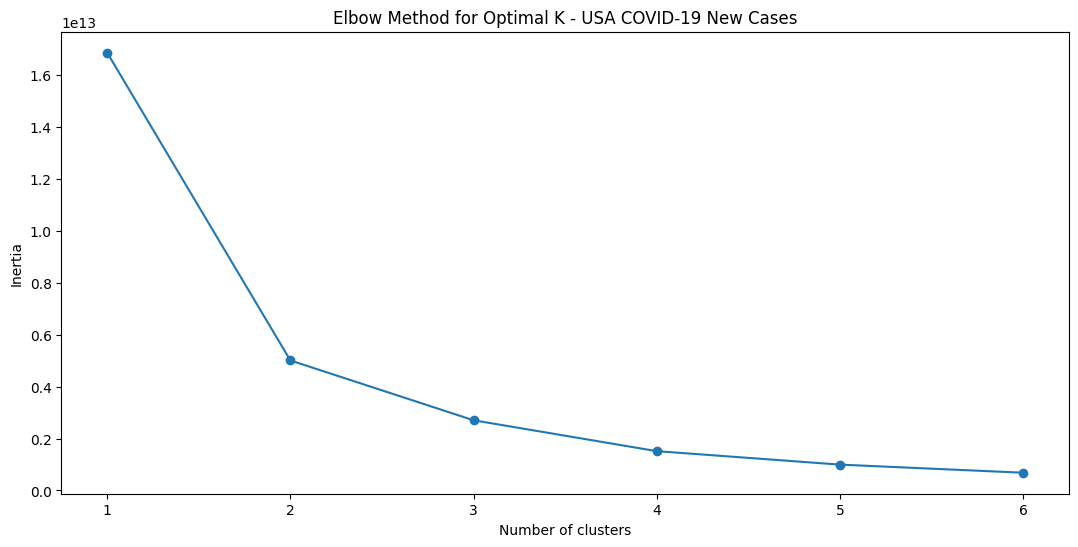

In [32]:
# Determined the optimal number of clusters using the Elbow method for the USA data without outliers
inertia = []
for k in range(1, 7):  # Testing k values from 1 to 6
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(usa_data_filtered[['New Cases']])
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(13, 6))
plt.plot(range(1, 7), inertia, marker='o')
plt.title('Elbow Method for Optimal K - USA COVID-19 New Cases')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [33]:
#Preparing data for clustering
X_filtered = usa_data_filtered[['New Cases']]

# Perform K-Means clustering with the optimal number of clusters determined
kmeans = KMeans(n_clusters=3, random_state=0)
 # Scaling the data before clustering
clusters = kmeans.fit_predict(scale(X_filtered)) 

# Add the cluster information back to the DataFrame
usa_data_filtered['Cluster'] = clusters



C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rabby\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rabby\AppData\Local\Temp\ipykernel_19048\3153966238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data_filtered['Cluster'] = clusters


In [34]:
usa_data_filtered


,New Cases,Cluster
WeekNumber,,
1.0,5.0,0
2.0,6.0,0
3.0,2.0,0
4.0,1.0,0
5.0,2.0,0
...,...,...
160.0,257530.0,0
161.0,264445.0,0
162.0,244786.0,0


C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\rabby\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


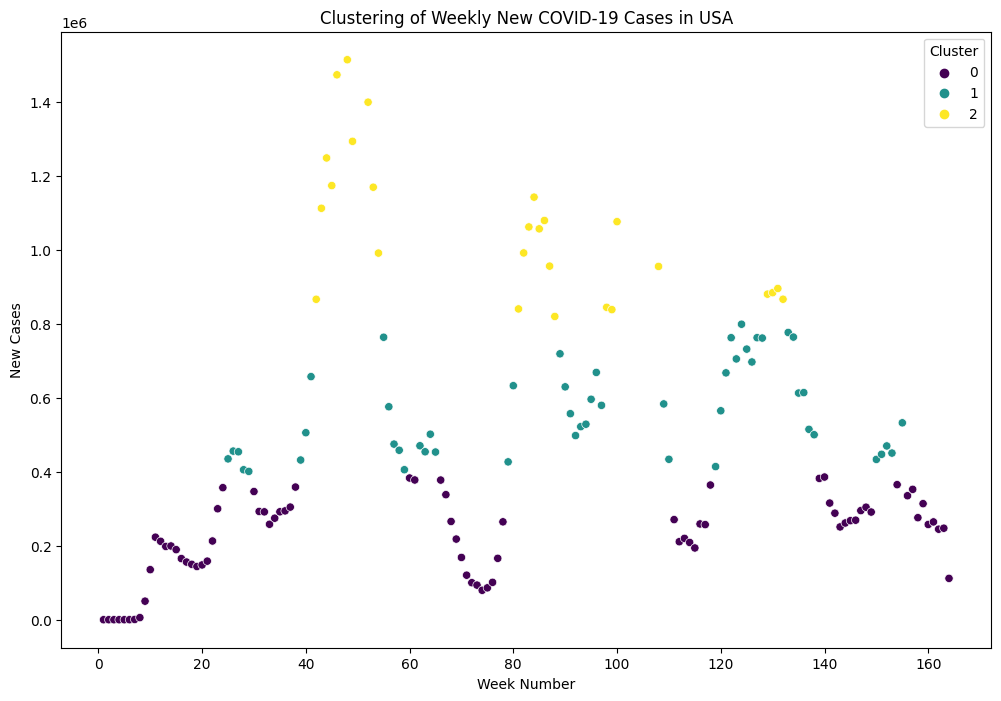

            New Cases  Cluster
WeekNumber                    
1.0               5.0        0
2.0               6.0        0
3.0               2.0        0
4.0               1.0        0
5.0               2.0        0


In [35]:
# Visualizing the clustering results
plt.figure(figsize=(12, 8))
sns.scatterplot(x=usa_data_filtered.index, y='New Cases', hue='Cluster', data=usa_data_filtered, palette='viridis', legend='full')
plt.title('Clustering of Weekly New COVID-19 Cases in USA')
plt.xlabel('Week Number')
plt.ylabel('New Cases')
plt.show()

# Output the DataFrame with clusters
print(usa_data_filtered.head())


In [36]:
#Calculated the silhouette score using the data used for clustering and the cluster labels
score = silhouette_score(X_filtered, clusters)
print('Silhouette Score:', score)


Silhouette Score: 0.5471590505576108


# Graph Analytics

**Task 1: Created graph analytics based on the weekly COVID-19 case counts for the US and its neighboring countries**

In [37]:
# Filtering the DataFrame for the USA and its neighboring countries
countries = ['US', 'Canada', 'Mexico', 'Brazil']
df_neighbors = df_weekly[df_weekly['Country/Region'].isin(countries)]

# Pivoted the data to have countries as columns and weeks as rows
df_pivot = df_neighbors.pivot(index='WeekNumber', columns='Country/Region', values='Cases').fillna(0)

# Displayed the resulting DataFrame
print(df_pivot)


Country/Region    Brazil   Canada   Mexico         US
WeekNumber                                           
1.0                    0        3        0          5
2.0                    0        4        0         11
3.0                    0        5        0         13
4.0                    0        5        0         14
5.0                    0       11        0         16
...                  ...      ...      ...        ...
160.0           36953492  1584414  7410093  102934224
161.0           36987682  1590014  7430816  103198669
162.0           37052936  1594055  7451429  103443455
163.0           37081209  1598075  7475219  103690910
164.0           37076053  1601325  7483444  103802702

[164 rows x 4 columns]


**Task 2: Created a graph showing relationships between the USA and neighboring countries based on weekly COVID-19 cases**

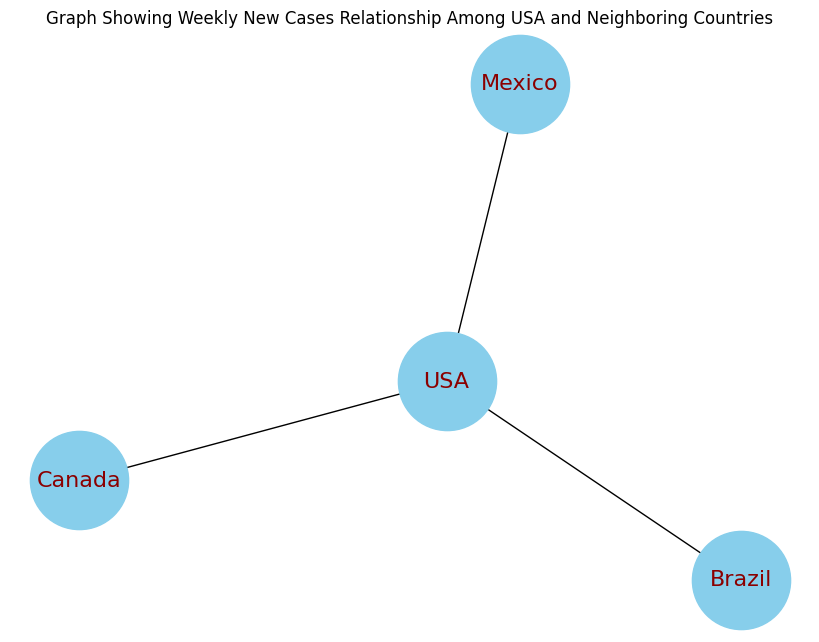

In [38]:
# Create a graph
G = nx.Graph()

# Define countries
countries = ['USA', 'Canada', 'Brazil', 'Mexico']

# Add nodes
for country in countries:
    G.add_node(country)

# Add edges between the USA and each of the neighboring countries
G.add_edge('USA', 'Canada')
G.add_edge('USA', 'Mexico')
G.add_edge('USA', 'Brazil')

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='k', node_size=5000, font_size=16, font_color='darkred')
plt.title('Graph Showing Weekly New Cases Relationship Among USA and Neighboring Countries')
plt.show()


**Task 3: Plot and compare the weekly COVID-19 infection trends for the US, Canada, Mexico, and Brazil**

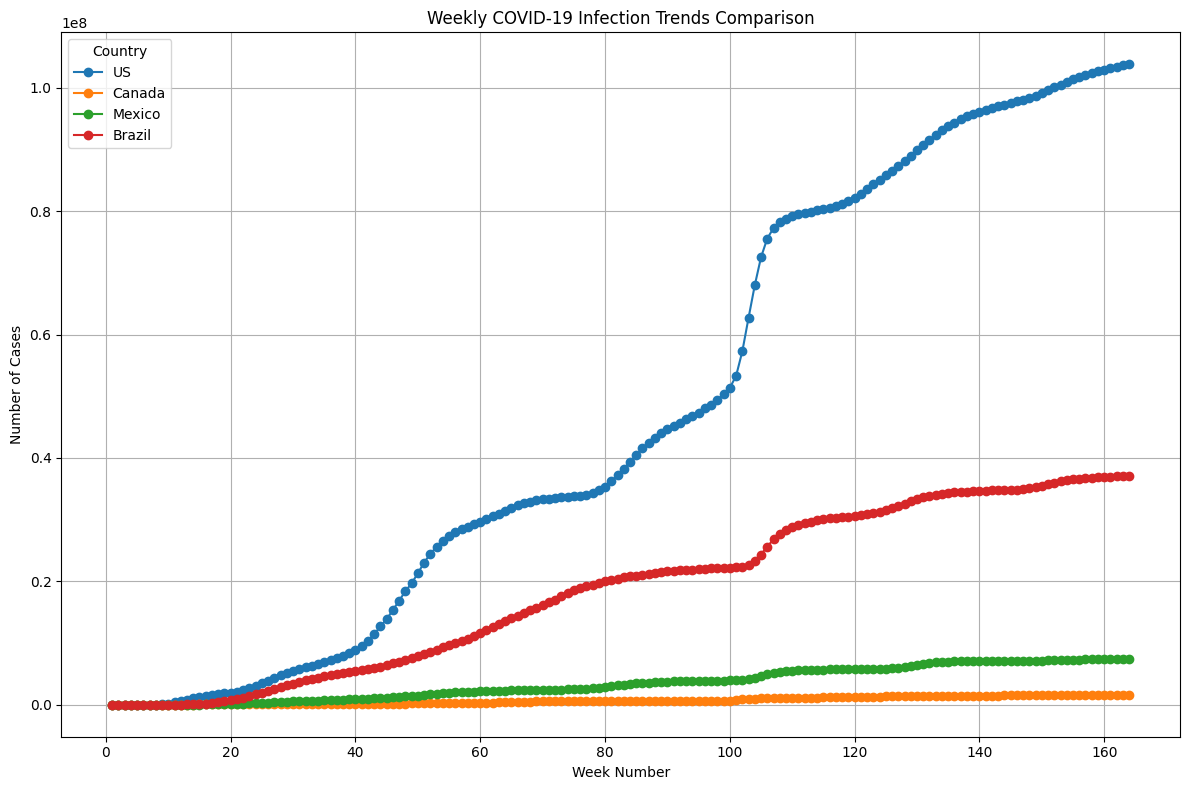

In [39]:
# Filtered data for the specific countries
countries = ['US', 'Canada', 'Mexico', 'Brazil']
df_filtered = df_weekly[df_weekly['Country/Region'].isin(countries)]

# Pivoted data to get countries as columns and WeekNumber as rows
df_pivot = df_filtered.pivot_table(index='WeekNumber', columns='Country/Region', values='Cases', aggfunc='max')

# Plotting
plt.figure(figsize=(12, 8))
for country in countries:
    plt.plot(df_pivot.index, df_pivot[country], label=country, marker='o')

plt.title('Weekly COVID-19 Infection Trends Comparison')
plt.xlabel('Week Number')
plt.ylabel('Number of Cases')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
# Load the dataset
df = pd.read_csv('time_series_covid19_confirmed_global.csv')

# Melt the DataFrame to change from wide to long format
df_long = df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Cases")

# Convert dates to datetime
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Calculate the 'WeekNumber' column
df_long["WeekNumber"] = df_long['Date'].dt.isocalendar().week + 52 * (df_long['Date'].dt.year - 2020)

# Aggregate the cases by country and week, computing new cases
df_weekly = df_long.groupby(['Country/Region', 'WeekNumber']).agg({'Cases': 'sum'}).reset_index()
df_weekly['New Cases'] = df_weekly.groupby('Country/Region')['Cases'].diff().fillna(0)

# Filter for relevant countries
countries = ['US', 'Canada', 'Mexico', 'Brazil']
df_weekly = df_weekly[df_weekly['Country/Region'].isin(countries)]

print(df_weekly.head())


     Country/Region  WeekNumber  Cases  New Cases
3936         Brazil           4      0        0.0
3937         Brazil           5      0        0.0
3938         Brazil           6      0        0.0
3939         Brazil           7      0        0.0
3940         Brazil           8      0        0.0


C:\Users\rabby\AppData\Local\Temp\ipykernel_19048\3521936691.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_long['Date'] = pd.to_datetime(df_long['Date'])


**Task 4: Generated a graph visualizing the correlation in weekly new COVID-19 case trends among the USA and neighboring countries**

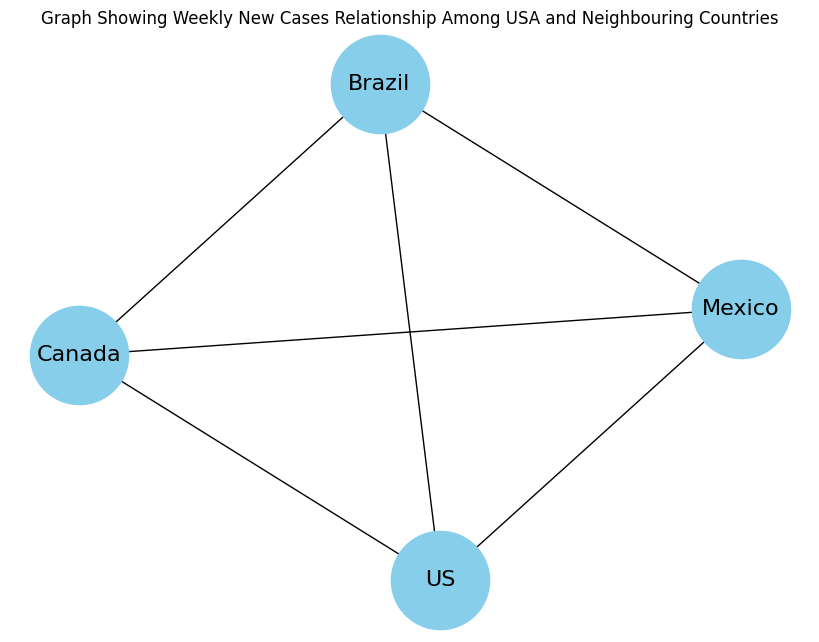

In [41]:
# Create a graph
G = nx.Graph()

# Add nodes
for country in countries:
    G.add_node(country)

# Add edges based on some criteria, e.g., similarities in new case trends
# calculated the similarity or a metric of closeness between these country trends
for i in range(len(countries)):
    for j in range(i + 1, len(countries)):
        # Example condition, this should ideally be based on a real metric of similarity
        if np.corrcoef(df_weekly[df_weekly['Country/Region'] == countries[i]]['New Cases'],
                       df_weekly[df_weekly['Country/Region'] == countries[j]]['New Cases'])[0, 1] > 0.8:
            G.add_edge(countries[i], countries[j])

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='k', node_size=5000, font_size=16)
plt.title('Graph Showing Weekly New Cases Relationship Among USA and Neighbouring Countries')
plt.show()


**Degree Centrality**

Calculated each centrality measure

In [42]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

**Plotting Degree Centrality**

**Defining plot_graph_with_centrality to visualize all the centrality measures**

In [43]:
def plot_graph_with_centrality(graph, centrality, title, centrality_label):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph)  # get positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_size=7000, node_color='skyblue')

    # Draw edges
    nx.draw_networkx_edges(graph, pos, width=2, alpha=0.5, edge_color='gray')

    # Draw node labels
    nx.draw_networkx_labels(graph, pos, font_size=16, font_weight='bold')

    # Annotate nodes with centrality scores
    for node, value in centrality.items():
        plt.text(pos[node][0], pos[node][1]+0.1, s=f'{centrality_label} {value:.2f}',
                 bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')

    plt.title(title)
    plt.axis('off')  
    plt.show()


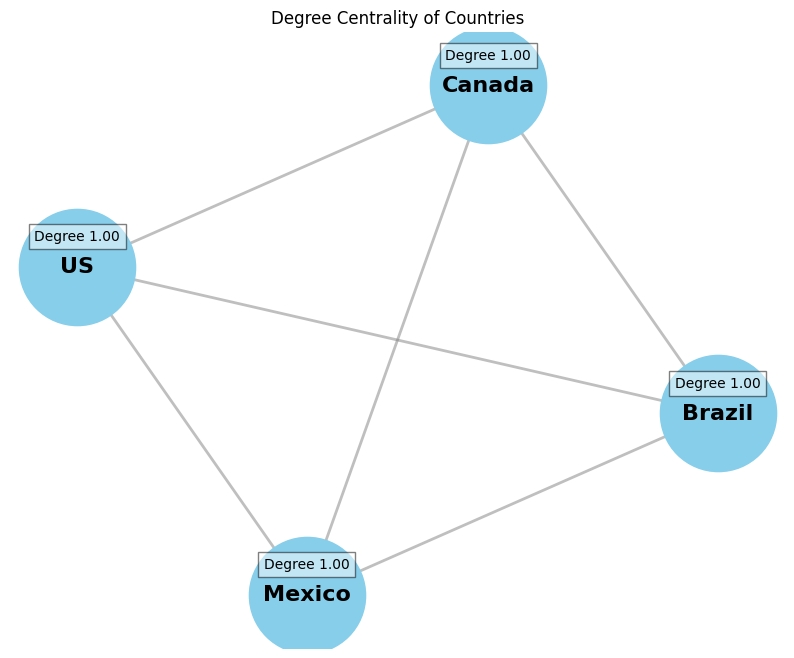

In [44]:
plot_graph_with_centrality(G, degree_centrality, 'Degree Centrality of Countries', 'Degree')


**Plotting Betweenness Centrality**

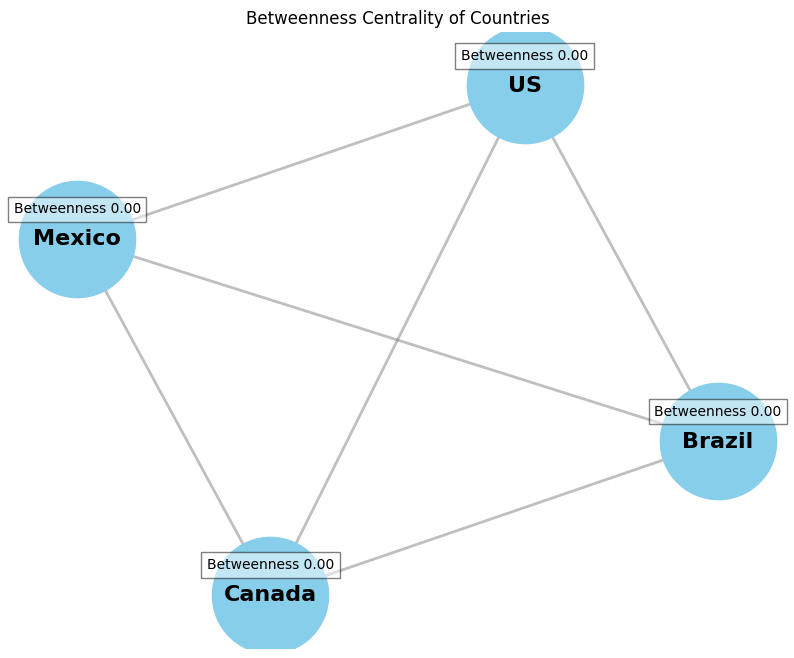

In [45]:
plot_graph_with_centrality(G, betweenness_centrality, 'Betweenness Centrality of Countries', 'Betweenness')

**Plotting Closeness Centrality**

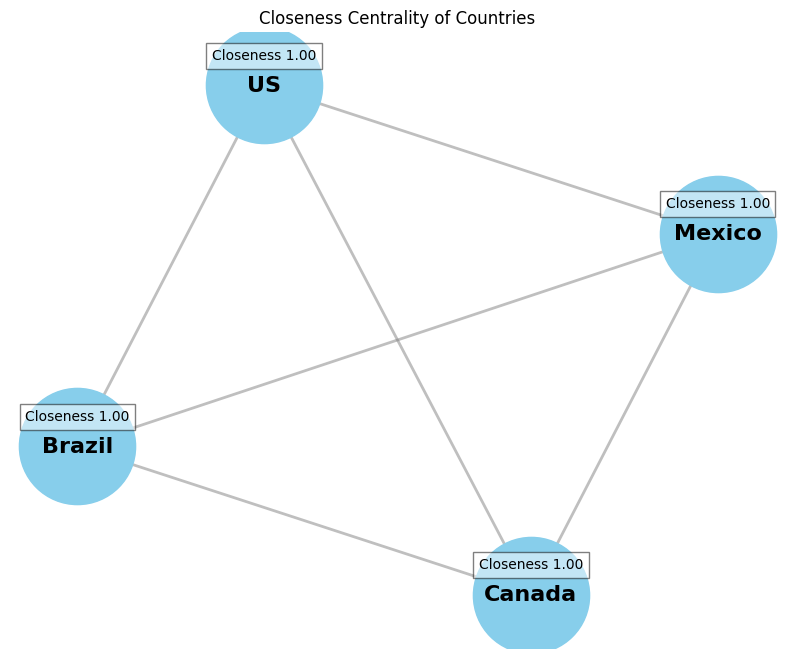

In [46]:

plot_graph_with_centrality(G, closeness_centrality, 'Closeness Centrality of Countries', 'Closeness')

**Plotting Eigenvector Centrality**

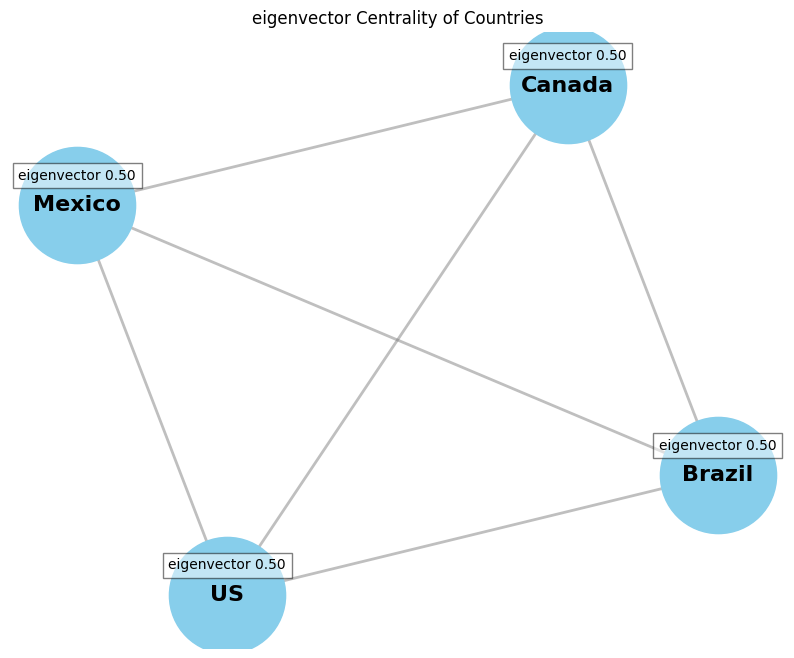

In [47]:
plot_graph_with_centrality(G, eigenvector_centrality, 'eigenvector Centrality of Countries', 'eigenvector')